## Statistics of Inverse design using gradient opt

We process only 100 samples here.

In order to produce results similar to the paper, use `df_test` (containing all 2500 samples).

## Import modules

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

2025-03-19 10:34:58.919711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742376898.936964 3044470 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742376898.942143 3044470 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 10:34:58.959359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load runtime

In [3]:
with open("runtime/gradient_inverse_runtime.pkl", "rb") as f:
    loaded_runtimes = pickle.load(f)

loaded_runtimes.head()

,Sample,Runtime (seconds)
0,1,15.094344
1,2,14.956331
2,3,15.149766
3,4,15.093807
4,5,14.944283


In [4]:
# Sum the 'Runtime (seconds)' column
total_runtime = loaded_runtimes["Runtime (seconds)"].sum()
avr_runtime = loaded_runtimes["Runtime (seconds)"].mean()

print("Total Runtime (seconds):", total_runtime)
print("Total avr_runtime (seconds):", avr_runtime)

Total Runtime (seconds): 1497.9544756412506
Total avr_runtime (seconds): 14.979544756412507


## Load test data and optimized from inverse design gradient-based

In [5]:
hdf5_df_file = "datasets/core_shell_particles_raw_122500_test_with_pred.h5"
df_test = pd.read_hdf(hdf5_df_file)
df_test.head()  # 2500 samples

with open("best_geometries/gradient_inverse_test_data.pkl", "rb") as f:
    final_best_geometries_df = pickle.load(f)

final_best_geometries_df.head()

,mat_core,mat_shell,r_core,r_shell,Total Loss,Sample,predicted_Qfwd,predicted_Qback,mie_Qfwd,mie_Qback,log_Qfwd,log_Qback
0,Si3N4,Si,38.608547,132.146255,0.000085,1,"[8.743148803710938, 7.798703670501709, 6.37121...","[0.6531610488891602, 0.4426010549068451, 0.557...","[8.640238488200614, 7.846710352582983, 6.27778...","[0.6671531046393501, 0.44448338671821863, 0.55...","[2.265945847756337, 2.1800456783454227, 1.9848...","[0.511117443965944, 0.36775173979759196, 0.444..."
1,Au,Si3N4,64.528732,91.107384,0.000024,2,"[2.9729716777801514, 2.8541548252105713, 2.712...","[0.2586507201194763, 0.2723049819469452, 0.292...","[2.968624455031121, 2.8256808535952618, 2.6933...","[0.2570695685589054, 0.27063707700378375, 0.28...","[1.3784195497805336, 1.3417364523781492, 1.306...","[0.228783272992234, 0.2395184101295558, 0.2516..."
2,SiO2,SiO2,8.197314,63.836575,0.001219,3,"[0.43795984983444214, 0.40468156337738037, 0.3...","[0.16609422862529755, 0.1605709046125412, 0.15...","[0.438275306737997, 0.40813270264231033, 0.380...","[0.16753281367386985, 0.16136237988757696, 0.1...","[0.3634446921135044, 0.3422645023304211, 0.322...","[0.15489281609646058, 0.1495937813936183, 0.14..."
3,ZrO2,ZrO2,8.27376,114.098946,0.000036,4,"[19.226835250854492, 16.326990127563477, 14.47...","[2.042360782623291, 1.6524603366851807, 1.4473...","[19.374567234626795, 16.28290895864681, 14.360...","[2.034854279291565, 1.6203112118805536, 1.4122...","[3.014287418883037, 2.8497180917221816, 2.7317...","[1.1101634099457875, 0.9632930938793611, 0.880..."
4,Au,TiO2,49.631756,79.075127,0.000250,5,"[5.816237926483154, 6.035409450531006, 6.35834...","[2.065091371536255, 2.100466728210449, 1.98399...","[5.712992555399698, 6.0070799348340005, 6.3316...","[2.12613556125396, 2.070087323727204, 1.997170...","[1.9040448359733833, 1.9469210571774738, 1.992...","[1.1397975967832545, 1.1217060054053927, 1.097..."


## Inverse Design Statistics

In [6]:
# Convert relevant columns from DataFrame to NumPy arrays
qfwd_target = np.vstack(df_test["Q_fwd"])
qfwd_mie = np.vstack(final_best_geometries_df["mie_Qfwd"])

qback_target = np.vstack(df_test["Q_back"])
qback_mie = np.vstack(final_best_geometries_df["mie_Qback"])

# Calculate performance metrics
mse_Qfwd = np.abs(qfwd_target - qfwd_mie) ** 2
mae_Qfwd = np.abs(qfwd_target - qfwd_mie)

mse_Qback = np.abs(qback_target - qback_mie) ** 2
mae_Qback = np.abs(qback_target - qback_mie)

# Print the results
print(f"Inverse Design Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

ValueError: operands could not be broadcast together with shapes (2500,64) (100,64) 

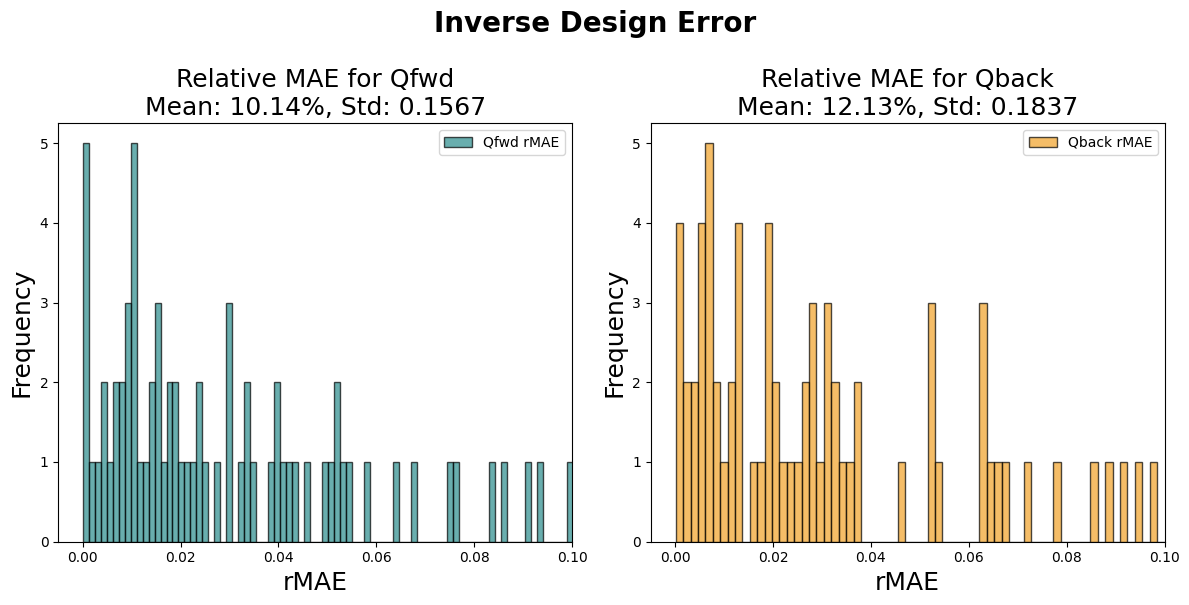

In [ ]:
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_target.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_target.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Inverse Design Error", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=700,
    color="#298c8cff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=600,
    color="#f1a226ff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

plt.tight_layout()
plt.show()

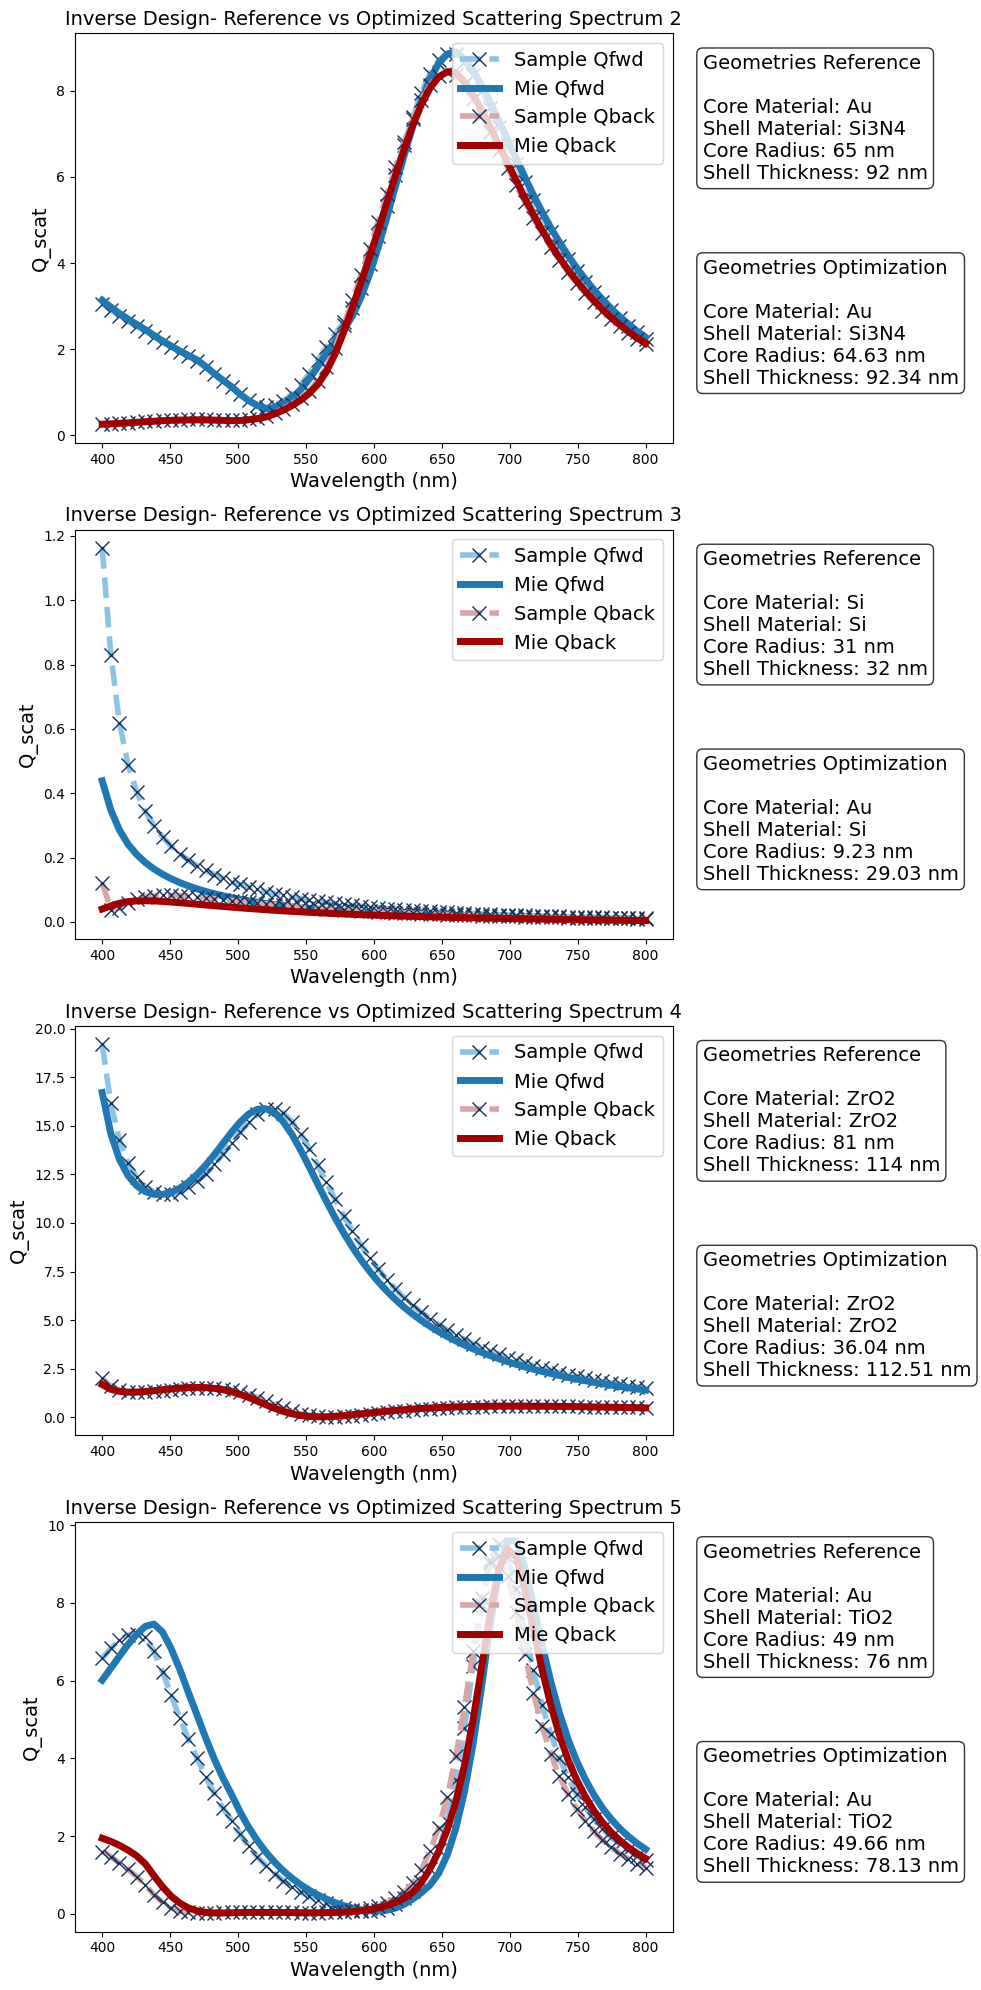

In [ ]:
wavelengths = np.linspace(400, 800, 64)
wavelengths_new = np.linspace(400, 800, 64)
sample_indices = [1, 2, 3, 4]

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for idx, sample_idx in enumerate(sample_indices):

    # Extract the relevant values from the best_geometries DataFrame for the optimized geometry
    core_material_optimized = final_best_geometries_df["mat_core"].values[sample_idx]
    shell_material_optimized = final_best_geometries_df["mat_shell"].values[sample_idx]
    core_radius_optimized = final_best_geometries_df["r_core"].values[sample_idx]
    shell_thickness_optimized = final_best_geometries_df["r_shell"].values[sample_idx]

    # Plot Qfwd on the left (first column)
    axes[idx].plot(
        wavelengths,
        df_test["Q_fwd"].iloc[sample_idx],
        label="Sample Qfwd",
        marker="x",
        markersize=10,
        color="#8cc5e3ff",
        linestyle="--",
        markerfacecolor="#16325bff",
        markeredgecolor="#16325bff",
        linewidth=4,
    )
    axes[idx].plot(
        wavelengths_new,
        final_best_geometries_df["mie_Qfwd"].iloc[sample_idx],
        label="Mie Qfwd",
        markersize=8,
        color="#1f77b4ff",
        linewidth=5,
    )
    annotation_text_sample = (
        f"Geometries Reference\n\n"
        f"Core Material: {df_test['mat_core'].iloc[sample_idx]}\n"
        f"Shell Material: {df_test['mat_shell'].iloc[sample_idx]}\n"
        f"Core Radius: {df_test['r_core'].iloc[sample_idx]} nm\n"
        f"Shell Thickness: {df_test['r_shell'].iloc[sample_idx]} nm"
    )
    axes[idx].annotate(
        annotation_text_sample,
        xy=(1.05, 0.95),
        xycoords="axes fraction",
        fontsize=14,
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
        ),
        verticalalignment="top",
    )
    annotation_text_optimized = (
        f"Geometries Optimization\n\n"
        f"Core Material: {core_material_optimized}\n"
        f"Shell Material: {shell_material_optimized}\n"
        f"Core Radius: {core_radius_optimized:.2f} nm\n"
        f"Shell Thickness: {shell_thickness_optimized:.2f} nm"
    )

    axes[idx].annotate(
        annotation_text_optimized,
        xy=(1.05, 0.45),
        xycoords="axes fraction",
        fontsize=14,
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
        ),
        verticalalignment="top",
    )

    axes[idx].set_xlabel("Wavelength (nm)", fontsize=14)
    axes[idx].set_ylabel("Q_scat", fontsize=14)
    axes[idx].legend(fontsize=14, loc="upper right", frameon=True)

    axes[idx].plot(
        wavelengths,
        df_test["Q_back"].iloc[sample_idx],
        label="Sample Qback",
        marker="x",
        markersize=10,
        color="#d8a6a6ff",
        linestyle="--",
        markerfacecolor="#16325bff",
        markeredgecolor="#16325bff",
        linewidth=4,
    )
    axes[idx].plot(
        wavelengths_new,
        final_best_geometries_df["mie_Qback"].iloc[sample_idx],
        label="Mie Qback",
        markersize=8,
        color="#a00000ff",
        linewidth=5,
    )

    axes[idx].set_xlabel("Wavelength (nm)", fontsize=14)
    axes[idx].set_title(
        f"Inverse Design- Reference vs Optimized Scattering Spectrum {sample_idx + 1}",
        fontsize=14,
    )
    axes[idx].legend(fontsize=14, loc="upper right", frameon=True)


plt.tight_layout()
plt.show()